<a href="https://colab.research.google.com/github/dk-wei/super-duper-transformer/blob/main/Sentence_Transformers_(Siamese_Network_%2B_Bert)_Modeling_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.0.1)


# Create Split Training Dataset

In [2]:
"""
The Quora Duplicate Questions dataset contains questions pairs from Quora (www.quora.com)
along with a label whether the two questions are a duplicate, i.e., have an identical itention.
Example of a duplicate pair:
How do I enhance my English?  AND  How can I become good at English?
Example of a non-duplicate pair:
How are roads named?   AND    How are airport runways named?
More details and the original Quora dataset can be found here:
https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs
Dataset: http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv
You do not need to run this script. You can download all files from here:
https://sbert.net/datasets/quora-duplicate-questions.zip
This script does the following:
1) After reading the quora_duplicate_questions.tsv, as provided by Quora, we add a transitive closure: If question (A, B) are duplicates and (B, C) are duplicates, than (A, C) must also be a duplicate. We add these missing links.
2) Next, we split sentences into train, dev, and test with a ratio of about 85% / 5% / 10%. In contrast to must other Quora data splits, like the split provided by GLUE, we ensure that the three sets are overlap free, i.e., no sentences in dev / test will appear in the train dataset. In order to achieve three distinct datasets, we pick a sentence and then assign all duplicate sentences to this dataset to that repective set
3) After distributing sentences to the three dataset split, we create files to facilitate 3 different tasks:
    3.1) Classification - Given two sentences, are these a duplicate? This is identical to the orginial Quora task and the task in GLUE, but with the big difference that sentences in dev / test have not been seen in train.
    3.2) Duplicate Question Mining - Given a large set of questions, identify all duplicates. The dev set consists of about 50k questions, the test set of about 100k sentences.
    3.3) Information Retrieval - Given a question as query, find in a large corpus (~350k questions) the duplicates of the query question.
The output consists of the following files:
quora_duplicate_questions.tsv - Original file provided by Quora (https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs)
classification/
    train/dev/test_pairs.tsv - Distinct sets of question pairs with label for duplicate / non-duplicate. These splits can be used for sentence pair classification tasks
duplicate-mining/ - Given a large set of questions, find all duplicates.
    _corpus.tsv - Large set of sentences
    _duplicates.tsv - All duplicate questions in the respective corpus.tsv
information-retrieval/  - Given a large corpus of questions, find the duplicates for a given query
    corpus.tsv - This file will be used for train/dev/test. It contains all questions in the corpus
    dev/test-queries.tsv - Queries and the respective duplicate questions (QIDs) in the corpus
"""
import csv
from collections import defaultdict
import random
import os
from sentence_transformers import util


random.seed(42)

#Get raw file
source_file = "quora-IR-dataset/quora_duplicate_questions.tsv"
os.makedirs('quora-IR-dataset', exist_ok=True)
os.makedirs('quora-IR-dataset/graph', exist_ok=True)
os.makedirs('quora-IR-dataset/information-retrieval', exist_ok=True)
os.makedirs('quora-IR-dataset/classification', exist_ok=True)
os.makedirs('quora-IR-dataset/duplicate-mining', exist_ok=True)

if not os.path.exists(source_file):
    print("Download file to", source_file)
    util.http_get('http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv', source_file)

#Read pairwise file
sentences = {}
duplicates = defaultdict(lambda: defaultdict(bool))
rows = []
with open(source_file, encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        id1 = row['qid1']
        id2 = row['qid2']
        question1 = row['question1'].replace("\r", "").replace("\n", " ").replace("\t", " ")
        question2 = row['question2'].replace("\r", "").replace("\n", " ").replace("\t", " ")
        is_duplicate = row['is_duplicate']

        if question1 == "" or question2 == "":
            continue

        sentences[id1] = question1
        sentences[id2] = question2

        rows.append({'qid1': id1, 'qid2': id2, 'question1': question1, 'question2': question2, 'is_duplicate': is_duplicate})

        if is_duplicate == '1':
            duplicates[id1][id2] = True
            duplicates[id2][id1] = True


# Search for (near) exact duplicates
# The original Quora duplicate questions dataset is an incomplete annotation,
# i.e., there are several duplicate question pairs which are not marked as duplicates.
# These missing annotation can make it difficult to compare approaches.
# Here we use a simple approach that searches for near identical questions, that only differ in maybe a stopword
# We mark these found question pairs also as duplicate to increase the annotation coverage
stopwords = set(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'which', 'while', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'])

num_new_duplicates = 0
sentences_norm = {}

for id, sent in sentences.items():
    sent_norm = sent.lower()

    #Replace some common paraphrases
    sent_norm = sent_norm.replace("how do you", "how do i").replace("how do we", "how do i")
    sent_norm = sent_norm.replace("how can we", "how can i").replace("how can you", "how can i").replace("how can i", "how do i")
    sent_norm = sent_norm.replace("really true", "true")
    sent_norm = sent_norm.replace("what are the importance", "what is the importance")
    sent_norm = sent_norm.replace("what was", "what is")
    sent_norm = sent_norm.replace("so many", "many")
    sent_norm = sent_norm.replace("would it take", "will it take")

    #Remove any punctuation characters
    for c in [",", "!", ".", "?", "'", '"', ":", ";", "[", "]", "{", "}", "<", ">"]:
        sent_norm = sent_norm.replace(c, " ")

    #Remove stop words
    tokens = sent_norm.split()
    tokens = [token for token in tokens if token not in stopwords]
    sent_norm = "".join(tokens)


    if sent_norm in sentences_norm:
        if not duplicates[id][sentences_norm[sent_norm]]:
            num_new_duplicates += 1

        duplicates[id][sentences_norm[sent_norm]] = True
        duplicates[sentences_norm[sent_norm]][id] = True
    else:
        sentences_norm[sent_norm] = id


print("(Nearly) exact duplicates found:", num_new_duplicates)


#Add transitive closure (if a,b and b,c duplicates => a,c are duplicates)
new_entries = True
while new_entries:
    print("Add transitive closure")
    new_entries = False
    for a in sentences:
        for b in list(duplicates[a]):
            for c in list(duplicates[b]):
                if a != c and not duplicates[a][c]:
                    new_entries = True
                    duplicates[a][c] = True
                    duplicates[c][a] = True


#Distribute rows to train/dev/test split
#Ensure that sets contain distinct sentences
is_assigned = set()
random.shuffle(rows)

train_ids = set()
dev_ids = set()
test_ids = set()

counter = 0
for row in rows:
    if row['qid1'] in is_assigned and row['qid2'] in is_assigned:
        continue
    elif row['qid1'] in is_assigned or row['qid2'] in is_assigned:

        if row['qid2'] in is_assigned: #Ensure that qid1 is assigned and qid2 not yet
            row['qid1'], row['qid2'] = row['qid2'], row['qid1']

        #Move qid2 to the same split as qid1
        target_set = train_ids
        if row['qid1'] in dev_ids:
            target_set = dev_ids
        elif row['qid1'] in test_ids:
            target_set = test_ids

    else:
        #Distribution about 85%/5%/10%
        target_set = train_ids
        if counter%10 == 0:
            target_set = dev_ids
        elif counter%10 == 1 or counter%10 == 2:
            target_set = test_ids
        counter += 1

    #Get the sentence with all duplicates and add it to the respective sets
    target_set.add(row['qid1'])
    is_assigned.add(row['qid1'])

    target_set.add(row['qid2'])
    is_assigned.add(row['qid2'])

    for b in list(duplicates[row['qid1']])+list(duplicates[row['qid2']]):
        target_set.add(b)
        is_assigned.add(b)


#Assert all sets are mutually exclusive
assert len(train_ids.intersection(dev_ids)) == 0
assert len(train_ids.intersection(test_ids)) == 0
assert len(test_ids.intersection(dev_ids)) == 0


print("\nTrain sentences:", len(train_ids))
print("Dev sentences:", len(dev_ids))
print("Test sentences:", len(test_ids))

#Extract the ids for duplicate questions for train/dev/test
def get_duplicate_set(ids_set):
    dups_set = set()
    for a in ids_set:
        for b in duplicates[a]:
            ids = sorted([a,b])
            dups_set.add(tuple(ids))
    return dups_set

train_duplicates = get_duplicate_set(train_ids)
dev_duplicates = get_duplicate_set(dev_ids)
test_duplicates = get_duplicate_set(test_ids)


print("\nTrain duplicates", len(train_duplicates))
print("Dev duplicates", len(dev_duplicates))
print("Test duplicates", len(test_duplicates))

############### Write general files about the duplate questions graph ############
with open('quora-IR-dataset/graph/sentences.tsv', 'w', encoding='utf8') as fOut:
    fOut.write("qid\tquestion\n")
    for id, question in sentences.items():
        fOut.write("{}\t{}\n".format(id, question))

duplicates_list = set()
for a in duplicates:
    for b in duplicates[a]:
        duplicates_list.add(tuple(sorted([int(a), int(b)])))


duplicates_list = list(duplicates_list)
duplicates_list = sorted(duplicates_list, key=lambda x: x[0]*1000000+x[1])


print("\nWrite duplicate graph in pairwise format")
with open('quora-IR-dataset/graph/duplicates-graph-pairwise.tsv', 'w', encoding='utf8') as fOut:
    fOut.write("qid1\tqid2\n")
    for a, b in duplicates_list:
        fOut.write("{}\t{}\n".format(a, b))


print("Write duplicate graph in list format")
with open('quora-IR-dataset/graph/duplicates-graph-list.tsv', 'w', encoding='utf8') as fOut:
    fOut.write("qid1\tqid2\n")
    for a in sorted(duplicates.keys(), key=lambda x: int(x)):
        if len(duplicates[a]) > 0:
            fOut.write("{}\t{}\n".format(a, ",".join(sorted(duplicates[a]))))

print("Write duplicate graph in connected subgraph format")
with open('quora-IR-dataset/graph/duplicates-graph-connected-nodes.tsv', 'w', encoding='utf8') as fOut:
    written_qids = set()
    fOut.write("qids\n")
    for a in sorted(duplicates.keys(), key=lambda x: int(x)):
        if a not in written_qids:
            ids = set()
            ids.add(a)

            for b in duplicates[a]:
                ids.add(b)

            fOut.write("{}\n".format(",".join(sorted(ids, key=lambda x: int(x)))))
            for id in ids:
                written_qids.add(id)

def write_qids(name, ids_list):
    with open('quora-IR-dataset/graph/'+name+'-questions.tsv', 'w', encoding='utf8') as fOut:
        fOut.write("qid\n")
        fOut.write("\n".join(sorted(ids_list, key=lambda x: int(x))))

write_qids('train', train_ids)
write_qids('dev', dev_ids)
write_qids('test', test_ids)


####### Output for duplicate mining #######
def write_mining_files(name, ids, dups):
    with open('quora-IR-dataset/duplicate-mining/'+name+'_corpus.tsv', 'w', encoding='utf8') as fOut:
        fOut.write("qid\tquestion\n")
        for id in ids:
            fOut.write("{}\t{}\n".format(id, sentences[id]))

    with open('quora-IR-dataset/duplicate-mining/'+name+'_duplicates.tsv', 'w', encoding='utf8') as fOut:
        fOut.write("qid1\tqid2\n")
        for a, b in dups:
            fOut.write("{}\t{}\n".format(a, b))


write_mining_files('train', train_ids, train_duplicates)
write_mining_files('dev', dev_ids, dev_duplicates)
write_mining_files('test', test_ids, test_duplicates)


###### Classification dataset #####
with open('quora-IR-dataset/classification/train_pairs.tsv', 'w', encoding='utf8') as fOutTrain, open('quora-IR-dataset/classification/dev_pairs.tsv', 'w', encoding='utf8') as fOutDev, open('quora-IR-dataset/classification/test_pairs.tsv', 'w', encoding='utf8') as fOutTest:
    fOutTrain.write("\t".join(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])+"\n")
    fOutDev.write("\t".join(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate']) + "\n")
    fOutTest.write("\t".join(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate']) + "\n")

    for row in rows:
        id1 = row['qid1']
        id2 = row['qid2']

        target = None
        if id1 in train_ids and id2 in train_ids:
            target = fOutTrain
        elif id1 in dev_ids and id2 in dev_ids:
            target = fOutDev
        elif id1 in test_ids and id2 in test_ids:
            target = fOutTest

        if target is not None:
            target.write("\t".join([row['qid1'], row['qid2'], sentences[id1], sentences[id2], row['is_duplicate']]))
            target.write("\n")


####### Write files for Information Retrieval #####
num_dev_queries = 5000
num_test_queries = 10000

corpus_ids = train_ids.copy()
dev_queries = set()
test_queries = set()

#Create dev queries
rnd_dev_ids = sorted(list(dev_ids))
random.shuffle(rnd_dev_ids)

for a in rnd_dev_ids:
    if a not in corpus_ids:
        if len(dev_queries) < num_dev_queries and len(duplicates[a]) > 0:
            dev_queries.add(a)
        else:
            corpus_ids.add(a)

        for b in duplicates[a]:
            if b not in dev_queries:
                corpus_ids.add(b)

#Create test queries
rnd_test_ids = sorted(list(test_ids))
random.shuffle(rnd_test_ids)

for a in rnd_test_ids:
    if a not in corpus_ids:
        if len(test_queries) < num_test_queries and len(duplicates[a]) > 0:
            test_queries.add(a)
        else:
            corpus_ids.add(a)

        for b in duplicates[a]:
            if b not in test_queries:
                corpus_ids.add(b)

#Write output for information-retrieval
print("\nInformation Retrival Setup")
print("Corpus size:", len(corpus_ids))
print("Dev queries:", len(dev_queries))
print("Test queries:", len(test_queries))

with open('quora-IR-dataset/information-retrieval/corpus.tsv', 'w', encoding='utf8') as fOut:
    fOut.write("qid\tquestion\n")
    for id in sorted(corpus_ids, key=lambda id: int(id)):
        fOut.write("{}\t{}\n".format(id, sentences[id]))

with open('quora-IR-dataset/information-retrieval/dev-queries.tsv', 'w', encoding='utf8') as fOut:
    fOut.write("qid\tquestion\tduplicate_qids\n")
    for id in sorted(dev_queries, key=lambda id: int(id)):
        fOut.write("{}\t{}\t{}\n".format(id, sentences[id], ",".join(duplicates[id])))

with open('quora-IR-dataset/information-retrieval/test-queries.tsv', 'w', encoding='utf8') as fOut:
    fOut.write("qid\tquestion\tduplicate_qids\n")
    for id in sorted(test_queries, key=lambda id: int(id)):
        fOut.write("{}\t{}\t{}\n".format(id, sentences[id], ",".join(duplicates[id])))


print("--DONE--")

(Nearly) exact duplicates found: 6328
Add transitive closure
Add transitive closure
Add transitive closure

Train sentences: 376493
Dev sentences: 53485
Test sentences: 107953

Train duplicates 217838
Dev duplicates 20017
Test duplicates 65350

Write duplicate graph in pairwise format
Write duplicate graph in list format
Write duplicate graph in connected subgraph format

Information Retrival Setup
Corpus size: 522931
Dev queries: 5000
Test queries: 10000
--DONE--


# Quora Duplicate Questions Training (MultipleNegativesRankingLoss)

In [3]:
from torch.utils.data import DataLoader
from sentence_transformers import losses, util
from sentence_transformers import LoggingHandler, SentenceTransformer, evaluation
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import csv
import os
from zipfile import ZipFile
import random

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout


#As base model, we use DistilBERT-base that was pre-trained on NLI and STSb data
model = SentenceTransformer('stsb-distilbert-base')
#model = SentenceTransformer('distilbert-base-nli-stsb-quora-ranking')

#Training for multiple epochs can be beneficial, as in each epoch a mini-batch is sampled differently
#hence, we get different negatives for each positive
num_epochs = 1

#Increasing the batch size improves the performance for MultipleNegativesRankingLoss. Choose it as large as possible
#I achieved the good results with a batch size of 300-350 (requires about 30 GB of GPU memory)
train_batch_size = 64

dataset_path = 'quora-IR-dataset'
model_save_path = 'output/training_MultipleNegativesRankingLoss-' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#eval_save_path = 'output/evaluation_MultipleNegativesRankingLoss-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(model_save_path, exist_ok=True)

# Check if the dataset exists. If not, download and extract
if not os.path.exists(dataset_path):
    logger.info("Dataset not found. Download")
    zip_save_path = 'quora-IR-dataset.zip'
    util.http_get(url='https://sbert.net/datasets/quora-IR-dataset.zip', path=zip_save_path)
    with ZipFile(zip_save_path, 'r') as zip:
        zip.extractall(dataset_path)

2021-03-19 02:09:21 - Load pretrained SentenceTransformer: stsb-distilbert-base
2021-03-19 02:09:21 - Did not find folder stsb-distilbert-base
2021-03-19 02:09:21 - Search model on server: http://sbert.net/models/stsb-distilbert-base.zip
2021-03-19 02:09:21 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_stsb-distilbert-base
2021-03-19 02:09:22 - Use pytorch device: cuda


In [4]:
######### Read train data  ##########
train_samples = []
max_train_samples = 100

with open(os.path.join(dataset_path, "classification/train_pairs.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
      # Counter += 1
      if row['is_duplicate'] == '1':
          train_samples.append(InputExample(texts=[row['question1'], row['question2']], label=1))
          train_samples.append(InputExample(texts=[row['question2'], row['question1']], label=1)) #if A is a duplicate of B, then B is a duplicate of A

          if len(train_samples) >= max_train_samples:
            break

# After reading the train_samples, we create a DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MultipleNegativesRankingLoss(model)

In [5]:
################### Development  Evaluators ##################
# We add 3 evaluators, that evaluate the model on Duplicate Questions pair classification,
# Duplicate Questions Mining, and Duplicate Questions Information Retrieval
evaluators = []

In [6]:
###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []
max_dev_pair_samples = 1000

with open(os.path.join(dataset_path, "classification/dev_pairs.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        dev_sentences1.append(row['question1'])
        dev_sentences2.append(row['question2'])
        dev_labels.append(int(row['is_duplicate']))

        if len(dev_sentences1) >= max_dev_pair_samples:
            break


binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)
evaluators.append(binary_acc_evaluator)

In [7]:
###### Duplicate Questions Mining ######
# Given a large corpus of questions, identify all duplicates in that corpus.
# For faster processing, we limit the development corpus to only 10,000 sentences.
max_dev_samples = 100000
dev_sentences = {}
dev_duplicates = []

with open(os.path.join(dataset_path, "duplicate-mining/dev_corpus.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        dev_sentences[row['qid']] = row['question']

        if len(dev_sentences) >= max_dev_samples:
            break

with open(os.path.join(dataset_path, "duplicate-mining/dev_duplicates.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['qid1'] in dev_sentences and row['qid2'] in dev_sentences:
            dev_duplicates.append([row['qid1'], row['qid2']])

# The ParaphraseMiningEvaluator computes the cosine similarity between all sentences and
# extracts a list with the pairs that have the highest similarity. Given the duplicate
# information in dev_duplicates, it then computes and F1 score how well our duplicate mining worked
paraphrase_mining_evaluator = evaluation.ParaphraseMiningEvaluator(dev_sentences, dev_duplicates, name='dev')
evaluators.append(paraphrase_mining_evaluator)

In [8]:
###### Duplicate Questions Information Retrieval ######
# Given a new question and a large corpus of thousands questions, find the most relevant (i.e. duplicate) question
# in that corpus.

# For faster processing, we limit the development corpus to only 10,000 sentences.
max_corpus_size = 100000

ir_queries = {}             #Our queries (qid => question)
ir_needed_qids = set()      #QIDs we need in the corpus
ir_corpus = {}              #Our corpus (qid => question)
ir_relevant_docs = {}       #Mapping of relevant documents for a given query (qid => set([relevant_question_ids])

with open(os.path.join(dataset_path, 'information-retrieval/dev-queries.tsv'), encoding='utf8') as fIn:
    next(fIn) #Skip header
    for line in fIn:
        qid, query, duplicate_ids = line.strip().split('\t')
        duplicate_ids = duplicate_ids.split(',')
        ir_queries[qid] = query
        ir_relevant_docs[qid] = set(duplicate_ids)

        for qid in duplicate_ids:
            ir_needed_qids.add(qid)

# First get all needed relevant documents (i.e., we must ensure, that the relevant questions are actually in the corpus
distraction_questions = {}
with open(os.path.join(dataset_path, 'information-retrieval/corpus.tsv'), encoding='utf8') as fIn:
    next(fIn) #Skip header
    for line in fIn:
        qid, question = line.strip().split('\t')

        if qid in ir_needed_qids:
            ir_corpus[qid] = question
        else:
            distraction_questions[qid] = question

# Now, also add some irrelevant questions to fill our corpus
other_qid_list = list(distraction_questions.keys())
random.shuffle(other_qid_list)

for qid in other_qid_list[0:max(0, max_corpus_size-len(ir_corpus))]:
    ir_corpus[qid] = distraction_questions[qid]

#Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR
# metrices. For our use case MRR@k and Accuracy@k are relevant.
ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_queries, ir_corpus, ir_relevant_docs)

evaluators.append(ir_evaluator)

In [9]:
evaluators

In [10]:
# Create a SequentialEvaluator. This SequentialEvaluator runs all three evaluators in a sequential order.
# We optimize the model with respect to the score from the last evaluator (scores[-1])
seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])

logger.info("Evaluate model without training")
#seq_evaluator(model, epoch=1, steps=0, output_path=model_save_path)
model.evaluate(evaluators[1])

logger.info("Evaluate model with training")
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          #evaluator=seq_evaluator,
          evaluator=evaluators[1],
          epochs=num_epochs,
          warmup_steps=1000,
          output_path=model_save_path
          )

2021-03-19 02:09:24 - Evaluate model without training
2021-03-19 02:09:24 - Paraphrase Mining Evaluation on dev dataset:
2021-03-19 02:10:21 - Number of candidate pairs: 265140
2021-03-19 02:10:22 - Average Precision: 42.00
2021-03-19 02:10:22 - Optimal threshold: 0.8632
2021-03-19 02:10:22 - Precision: 48.78
2021-03-19 02:10:22 - Recall: 43.95
2021-03-19 02:10:22 - F1: 46.24

2021-03-19 02:10:22 - Evaluate model with training



2021-03-19 02:10:22 - Paraphrase Mining Evaluation on dev dataset after epoch 0:
2021-03-19 02:11:18 - Number of candidate pairs: 265139
2021-03-19 02:11:18 - Average Precision: 41.99
2021-03-19 02:11:18 - Optimal threshold: 0.8632
2021-03-19 02:11:18 - Precision: 48.78
2021-03-19 02:11:18 - Recall: 43.95
2021-03-19 02:11:18 - F1: 46.24

2021-03-19 02:11:19 - Save model to output/training_MultipleNegativesRankingLoss-2021-03-19_02-09-22



# Quora Duplicate Questions Training (OnlineContrastiveLoss)

In [27]:
from torch.utils.data import DataLoader
from sentence_transformers import losses, util
from sentence_transformers import LoggingHandler, SentenceTransformer, evaluation
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import csv
import os
from zipfile import ZipFile
import random

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout


#As base model, we use DistilBERT-base that was pre-trained on NLI and STSb data
model = SentenceTransformer('stsb-distilbert-base')
num_epochs = 20
train_batch_size = 64

#As distance metric, we use cosine distance (cosine_distance = 1-cosine_similarity)
distance_metric = losses.SiameseDistanceMetric.COSINE_DISTANCE

#Negative pairs should have a distance of at least 0.5
margin = 0.5

dataset_path = 'quora-IR-dataset'
model_save_path = 'output/training_OnlineConstrativeLoss-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
eval_save_path = 'output/evaluation_OnlineConstrativeLoss-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(model_save_path, exist_ok=True)

# Check if the dataset exists. If not, download and extract
if not os.path.exists(dataset_path):
    logger.info("Dataset not found. Download")
    zip_save_path = 'quora-IR-dataset.zip'
    util.http_get(url='https://sbert.net/datasets/quora-IR-dataset.zip', path=zip_save_path)
    with ZipFile(zip_save_path, 'r') as zip:
        zip.extractall(dataset_path)


2021-03-19 02:28:56 - Load pretrained SentenceTransformer: stsb-distilbert-base
2021-03-19 02:28:56 - Did not find folder stsb-distilbert-base
2021-03-19 02:28:56 - Search model on server: http://sbert.net/models/stsb-distilbert-base.zip
2021-03-19 02:28:56 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_stsb-distilbert-base
2021-03-19 02:28:58 - Use pytorch device: cuda


In [28]:
######### Read train data  ##########
# Read train data
max_train_samples = 100
train_samples = []


with open(os.path.join(dataset_path, "classification/train_pairs.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        sample = InputExample(texts=[row['question1'], row['question2']], label=int(row['is_duplicate']))
        train_samples.append(sample)

        if len(train_samples) >= max_train_samples:
            break




train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.OnlineContrastiveLoss(model=model, distance_metric=distance_metric, margin=margin)





In [29]:
################### Development  Evaluators ##################
# We add 3 evaluators, that evaluate the model on Duplicate Questions pair classification,
# Duplicate Questions Mining, and Duplicate Questions Information Retrieval
evaluators = []

###### Classification ######
# Given (quesiton1, question2), is this a duplicate or not?
# The evaluator will compute the embeddings for both questions and then compute
# a cosine similarity. If the similarity is above a threshold, we have a duplicate.
dev_sentences1 = []
dev_sentences2 = []
dev_labels = []
with open(os.path.join(dataset_path, "classification/dev_pairs.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        dev_sentences1.append(row['question1'])
        dev_sentences2.append(row['question2'])
        dev_labels.append(int(row['is_duplicate']))


binary_acc_evaluator = evaluation.BinaryClassificationEvaluator(dev_sentences1, dev_sentences2, dev_labels)
evaluators.append(binary_acc_evaluator)


In [30]:
###### Duplicate Questions Mining ######
# Given a large corpus of questions, identify all duplicates in that corpus.

# For faster processing, we limit the development corpus to only 10,000 sentences.
max_dev_samples = 10000
dev_sentences = {}
dev_duplicates = []
with open(os.path.join(dataset_path, "duplicate-mining/dev_corpus.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        dev_sentences[row['qid']] = row['question']

        if len(dev_sentences) >= max_dev_samples:
            break

with open(os.path.join(dataset_path, "duplicate-mining/dev_duplicates.tsv"), encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['qid1'] in dev_sentences and row['qid2'] in dev_sentences:
            dev_duplicates.append([row['qid1'], row['qid2']])


# The ParaphraseMiningEvaluator computes the cosine similarity between all sentences and
# extracts a list with the pairs that have the highest similarity. Given the duplicate
# information in dev_duplicates, it then computes and F1 score how well our duplicate mining worked
paraphrase_mining_evaluator = evaluation.ParaphraseMiningEvaluator(dev_sentences, dev_duplicates, name='dev')
evaluators.append(paraphrase_mining_evaluator)




In [31]:
###### Duplicate Questions Information Retrieval ######
# Given a question and a large corpus of thousands questions, find the most relevant (i.e. duplicate) question
# in that corpus.

# For faster processing, we limit the development corpus to only 10,000 sentences.
max_corpus_size = 100000

ir_queries = {}             #Our queries (qid => question)
ir_needed_qids = set()      #QIDs we need in the corpus
ir_corpus = {}              #Our corpus (qid => question)
ir_relevant_docs = {}       #Mapping of relevant documents for a given query (qid => set([relevant_question_ids])

with open(os.path.join(dataset_path, 'information-retrieval/dev-queries.tsv'), encoding='utf8') as fIn:
    next(fIn) #Skip header
    for line in fIn:
        qid, query, duplicate_ids = line.strip().split('\t')
        duplicate_ids = duplicate_ids.split(',')
        ir_queries[qid] = query
        ir_relevant_docs[qid] = set(duplicate_ids)

        for qid in duplicate_ids:
            ir_needed_qids.add(qid)

# First get all needed relevant documents (i.e., we must ensure, that the relevant questions are actually in the corpus
distraction_questions = {}
with open(os.path.join(dataset_path, 'information-retrieval/corpus.tsv'), encoding='utf8') as fIn:
    next(fIn) #Skip header
    for line in fIn:
        qid, question = line.strip().split('\t')

        if qid in ir_needed_qids:
            ir_corpus[qid] = question
        else:
            distraction_questions[qid] = question

# Now, also add some irrelevant questions to fill our corpus
other_qid_list = list(distraction_questions.keys())
random.shuffle(other_qid_list)

for qid in other_qid_list[0:max(0, max_corpus_size-len(ir_corpus))]:
    ir_corpus[qid] = distraction_questions[qid]

#Given queries, a corpus and a mapping with relevant documents, the InformationRetrievalEvaluator computes different IR
# metrices. For our use case MRR@k and Accuracy@k are relevant.
ir_evaluator = evaluation.InformationRetrievalEvaluator(ir_queries, ir_corpus, ir_relevant_docs)

evaluators.append(ir_evaluator)



In [32]:
# Create a SequentialEvaluator. This SequentialEvaluator runs all three evaluators in a sequential order.
# We optimize the model with respect to the score from the last evaluator (scores[-1])
seq_evaluator = evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[-1])


logger.info("Evaluate model without training")
seq_evaluator(model, epoch=0, steps=0, output_path=model_save_path)

logger.info("Evaluate model with training")
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          #evaluator=seq_evaluator,
          evaluator=evaluators[0],
          epochs=num_epochs,
          warmup_steps=1000,
          save_best_model=True,  # If true, the best model (according to evaluator) is stored at output_path
          output_path=model_save_path
          )

2021-03-19 02:28:59 - Evaluate model without training
2021-03-19 02:28:59 - Binary Accuracy Evaluation of the model on  dataset in epoch 0 after 0 steps:
2021-03-19 02:29:51 - Accuracy with Cosine-Similarity:           76.61	(Threshold: 0.8349)
2021-03-19 02:29:51 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7391)
2021-03-19 02:29:51 - Precision with Cosine-Similarity:          60.18
2021-03-19 02:29:51 - Recall with Cosine-Similarity:             81.64
2021-03-19 02:29:51 - Average Precision with Cosine-Similarity:  71.80

2021-03-19 02:29:52 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 193.7356)
2021-03-19 02:29:52 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.4903)
2021-03-19 02:29:52 - Precision with Manhatten-Distance:          59.75
2021-03-19 02:29:52 - Recall with Manhatten-Distance:             82.88
2021-03-19 02:29:52 - Average Precision with Manhatten-Distance:  71.87

2021-03-19 02:29:52 - Accuracy with Euclidean


2021-03-19 02:31:23 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2021-03-19 02:32:16 - Accuracy with Cosine-Similarity:           76.61	(Threshold: 0.8201)
2021-03-19 02:32:16 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7391)
2021-03-19 02:32:16 - Precision with Cosine-Similarity:          60.17
2021-03-19 02:32:16 - Recall with Cosine-Similarity:             81.65
2021-03-19 02:32:16 - Average Precision with Cosine-Similarity:  71.80

2021-03-19 02:32:16 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 193.7391)
2021-03-19 02:32:16 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.4881)
2021-03-19 02:32:16 - Precision with Manhatten-Distance:          59.75
2021-03-19 02:32:16 - Recall with Manhatten-Distance:             82.88
2021-03-19 02:32:16 - Average Precision with Manhatten-Distance:  71.87

2021-03-19 02:32:16 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8833)
2021-03-19 02:32:


2021-03-19 02:32:18 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2021-03-19 02:33:10 - Accuracy with Cosine-Similarity:           76.61	(Threshold: 0.8201)
2021-03-19 02:33:10 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7391)
2021-03-19 02:33:10 - Precision with Cosine-Similarity:          60.18
2021-03-19 02:33:10 - Recall with Cosine-Similarity:             81.65
2021-03-19 02:33:10 - Average Precision with Cosine-Similarity:  71.80

2021-03-19 02:33:10 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 193.7229)
2021-03-19 02:33:10 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.4752)
2021-03-19 02:33:10 - Precision with Manhatten-Distance:          59.76
2021-03-19 02:33:10 - Recall with Manhatten-Distance:             82.88
2021-03-19 02:33:10 - Average Precision with Manhatten-Distance:  71.87

2021-03-19 02:33:11 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8815)
2021-03-19 02:33:


2021-03-19 02:33:12 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2021-03-19 02:34:05 - Accuracy with Cosine-Similarity:           76.62	(Threshold: 0.8202)
2021-03-19 02:34:05 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7373)
2021-03-19 02:34:05 - Precision with Cosine-Similarity:          59.99
2021-03-19 02:34:05 - Recall with Cosine-Similarity:             81.98
2021-03-19 02:34:05 - Average Precision with Cosine-Similarity:  71.80

2021-03-19 02:34:05 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 193.7090)
2021-03-19 02:34:05 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.4525)
2021-03-19 02:34:05 - Precision with Manhatten-Distance:          59.76
2021-03-19 02:34:05 - Recall with Manhatten-Distance:             82.88
2021-03-19 02:34:05 - Average Precision with Manhatten-Distance:  71.87

2021-03-19 02:34:05 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8811)
2021-03-19 02:34:


2021-03-19 02:34:07 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2021-03-19 02:35:00 - Accuracy with Cosine-Similarity:           76.62	(Threshold: 0.8203)
2021-03-19 02:35:00 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7373)
2021-03-19 02:35:00 - Precision with Cosine-Similarity:          59.98
2021-03-19 02:35:00 - Recall with Cosine-Similarity:             81.99
2021-03-19 02:35:00 - Average Precision with Cosine-Similarity:  71.81

2021-03-19 02:35:00 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 194.3625)
2021-03-19 02:35:00 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.0686)
2021-03-19 02:35:00 - Precision with Manhatten-Distance:          59.82
2021-03-19 02:35:00 - Recall with Manhatten-Distance:             82.75
2021-03-19 02:35:00 - Average Precision with Manhatten-Distance:  71.87

2021-03-19 02:35:00 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8797)
2021-03-19 02:35:


2021-03-19 02:35:02 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2021-03-19 02:35:54 - Accuracy with Cosine-Similarity:           76.62	(Threshold: 0.8202)
2021-03-19 02:35:54 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7390)
2021-03-19 02:35:54 - Precision with Cosine-Similarity:          60.14
2021-03-19 02:35:54 - Recall with Cosine-Similarity:             81.70
2021-03-19 02:35:54 - Average Precision with Cosine-Similarity:  71.81

2021-03-19 02:35:55 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 196.8915)
2021-03-19 02:35:55 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.0768)
2021-03-19 02:35:55 - Precision with Manhatten-Distance:          59.81
2021-03-19 02:35:55 - Recall with Manhatten-Distance:             82.76
2021-03-19 02:35:55 - Average Precision with Manhatten-Distance:  71.87

2021-03-19 02:35:55 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8770)
2021-03-19 02:35:


2021-03-19 02:35:56 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2021-03-19 02:36:49 - Accuracy with Cosine-Similarity:           76.62	(Threshold: 0.8203)
2021-03-19 02:36:49 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7397)
2021-03-19 02:36:49 - Precision with Cosine-Similarity:          60.20
2021-03-19 02:36:49 - Recall with Cosine-Similarity:             81.58
2021-03-19 02:36:49 - Average Precision with Cosine-Similarity:  71.81

2021-03-19 02:36:49 - Accuracy with Manhatten-Distance:           76.70	(Threshold: 196.8806)
2021-03-19 02:36:49 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.0535)
2021-03-19 02:36:49 - Precision with Manhatten-Distance:          59.81
2021-03-19 02:36:49 - Recall with Manhatten-Distance:             82.78
2021-03-19 02:36:49 - Average Precision with Manhatten-Distance:  71.88

2021-03-19 02:36:49 - Accuracy with Euclidean-Distance:           76.74	(Threshold: 8.8759)
2021-03-19 02:36:


2021-03-19 02:36:51 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2021-03-19 02:37:44 - Accuracy with Cosine-Similarity:           76.62	(Threshold: 0.8348)
2021-03-19 02:37:44 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7378)
2021-03-19 02:37:44 - Precision with Cosine-Similarity:          60.00
2021-03-19 02:37:44 - Recall with Cosine-Similarity:             81.96
2021-03-19 02:37:44 - Average Precision with Cosine-Similarity:  71.81

2021-03-19 02:37:44 - Accuracy with Manhatten-Distance:           76.71	(Threshold: 196.8314)
2021-03-19 02:37:44 - F1 with Manhatten-Distance:                 69.44	(Threshold: 240.6639)
2021-03-19 02:37:44 - Precision with Manhatten-Distance:          59.69
2021-03-19 02:37:44 - Recall with Manhatten-Distance:             83.01
2021-03-19 02:37:44 - Average Precision with Manhatten-Distance:  71.88

2021-03-19 02:37:45 - Accuracy with Euclidean-Distance:           76.74	(Threshold: 8.6954)
2021-03-19 02:37:


2021-03-19 02:37:46 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2021-03-19 02:38:39 - Accuracy with Cosine-Similarity:           76.63	(Threshold: 0.8349)
2021-03-19 02:38:39 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7379)
2021-03-19 02:38:39 - Precision with Cosine-Similarity:          60.00
2021-03-19 02:38:39 - Recall with Cosine-Similarity:             81.96
2021-03-19 02:38:39 - Average Precision with Cosine-Similarity:  71.82

2021-03-19 02:38:39 - Accuracy with Manhatten-Distance:           76.71	(Threshold: 192.6656)
2021-03-19 02:38:39 - F1 with Manhatten-Distance:                 69.45	(Threshold: 240.6174)
2021-03-19 02:38:39 - Precision with Manhatten-Distance:          59.69
2021-03-19 02:38:39 - Recall with Manhatten-Distance:             83.02
2021-03-19 02:38:39 - Average Precision with Manhatten-Distance:  71.88

2021-03-19 02:38:39 - Accuracy with Euclidean-Distance:           76.74	(Threshold: 8.8629)
2021-03-19 02:38:


2021-03-19 02:38:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2021-03-19 02:39:33 - Accuracy with Cosine-Similarity:           76.63	(Threshold: 0.8349)
2021-03-19 02:39:33 - F1 with Cosine-Similarity:                 69.27	(Threshold: 0.7377)
2021-03-19 02:39:33 - Precision with Cosine-Similarity:          59.95
2021-03-19 02:39:33 - Recall with Cosine-Similarity:             82.02
2021-03-19 02:39:33 - Average Precision with Cosine-Similarity:  71.82

2021-03-19 02:39:34 - Accuracy with Manhatten-Distance:           76.71	(Threshold: 196.7780)
2021-03-19 02:39:34 - F1 with Manhatten-Distance:                 69.45	(Threshold: 240.7450)
2021-03-19 02:39:34 - Precision with Manhatten-Distance:          59.64
2021-03-19 02:39:34 - Recall with Manhatten-Distance:             83.12
2021-03-19 02:39:34 - Average Precision with Manhatten-Distance:  71.89

2021-03-19 02:39:34 - Accuracy with Euclidean-Distance:           76.74	(Threshold: 8.9112)
2021-03-19 02:39:


2021-03-19 02:39:35 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2021-03-19 02:40:28 - Accuracy with Cosine-Similarity:           76.64	(Threshold: 0.8349)
2021-03-19 02:40:28 - F1 with Cosine-Similarity:                 69.28	(Threshold: 0.7380)
2021-03-19 02:40:28 - Precision with Cosine-Similarity:          59.97
2021-03-19 02:40:28 - Recall with Cosine-Similarity:             82.02
2021-03-19 02:40:28 - Average Precision with Cosine-Similarity:  71.83

2021-03-19 02:40:29 - Accuracy with Manhatten-Distance:           76.71	(Threshold: 191.9050)
2021-03-19 02:40:29 - F1 with Manhatten-Distance:                 69.46	(Threshold: 240.6230)
2021-03-19 02:40:29 - Precision with Manhatten-Distance:          59.66
2021-03-19 02:40:29 - Recall with Manhatten-Distance:             83.12
2021-03-19 02:40:29 - Average Precision with Manhatten-Distance:  71.89

2021-03-19 02:40:29 - Accuracy with Euclidean-Distance:           76.75	(Threshold: 8.8962)
2021-03-19 02:40:


2021-03-19 02:40:30 - Binary Accuracy Evaluation of the model on  dataset after epoch 10:
2021-03-19 02:41:23 - Accuracy with Cosine-Similarity:           76.63	(Threshold: 0.8350)
2021-03-19 02:41:23 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7381)
2021-03-19 02:41:23 - Precision with Cosine-Similarity:          59.96
2021-03-19 02:41:23 - Recall with Cosine-Similarity:             82.04
2021-03-19 02:41:23 - Average Precision with Cosine-Similarity:  71.83

2021-03-19 02:41:23 - Accuracy with Manhatten-Distance:           76.71	(Threshold: 191.7423)
2021-03-19 02:41:23 - F1 with Manhatten-Distance:                 69.48	(Threshold: 240.5603)
2021-03-19 02:41:23 - Precision with Manhatten-Distance:          59.67
2021-03-19 02:41:23 - Recall with Manhatten-Distance:             83.14
2021-03-19 02:41:23 - Average Precision with Manhatten-Distance:  71.90

2021-03-19 02:41:24 - Accuracy with Euclidean-Distance:           76.76	(Threshold: 8.8898)
2021-03-19 02:41


2021-03-19 02:41:25 - Binary Accuracy Evaluation of the model on  dataset after epoch 11:
2021-03-19 02:42:18 - Accuracy with Cosine-Similarity:           76.64	(Threshold: 0.8351)
2021-03-19 02:42:18 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7369)
2021-03-19 02:42:18 - Precision with Cosine-Similarity:          59.86
2021-03-19 02:42:18 - Recall with Cosine-Similarity:             82.24
2021-03-19 02:42:18 - Average Precision with Cosine-Similarity:  71.84

2021-03-19 02:42:18 - Accuracy with Manhatten-Distance:           76.72	(Threshold: 196.3824)
2021-03-19 02:42:18 - F1 with Manhatten-Distance:                 69.48	(Threshold: 240.3896)
2021-03-19 02:42:18 - Precision with Manhatten-Distance:          59.69
2021-03-19 02:42:18 - Recall with Manhatten-Distance:             83.10
2021-03-19 02:42:18 - Average Precision with Manhatten-Distance:  71.91

2021-03-19 02:42:18 - Accuracy with Euclidean-Distance:           76.76	(Threshold: 8.8890)
2021-03-19 02:42


2021-03-19 02:42:20 - Binary Accuracy Evaluation of the model on  dataset after epoch 12:
2021-03-19 02:43:12 - Accuracy with Cosine-Similarity:           76.64	(Threshold: 0.8360)
2021-03-19 02:43:12 - F1 with Cosine-Similarity:                 69.29	(Threshold: 0.7427)
2021-03-19 02:43:12 - Precision with Cosine-Similarity:          60.35
2021-03-19 02:43:12 - Recall with Cosine-Similarity:             81.34
2021-03-19 02:43:12 - Average Precision with Cosine-Similarity:  71.84

2021-03-19 02:43:12 - Accuracy with Manhatten-Distance:           76.72	(Threshold: 195.9733)
2021-03-19 02:43:12 - F1 with Manhatten-Distance:                 69.47	(Threshold: 240.4255)
2021-03-19 02:43:12 - Precision with Manhatten-Distance:          59.66
2021-03-19 02:43:12 - Recall with Manhatten-Distance:             83.14
2021-03-19 02:43:12 - Average Precision with Manhatten-Distance:  71.91

2021-03-19 02:43:13 - Accuracy with Euclidean-Distance:           76.77	(Threshold: 8.8825)
2021-03-19 02:43


2021-03-19 02:43:14 - Binary Accuracy Evaluation of the model on  dataset after epoch 13:
2021-03-19 02:44:07 - Accuracy with Cosine-Similarity:           76.64	(Threshold: 0.8362)
2021-03-19 02:44:07 - F1 with Cosine-Similarity:                 69.31	(Threshold: 0.7433)
2021-03-19 02:44:07 - Precision with Cosine-Similarity:          60.40
2021-03-19 02:44:07 - Recall with Cosine-Similarity:             81.32
2021-03-19 02:44:07 - Average Precision with Cosine-Similarity:  71.85

2021-03-19 02:44:07 - Accuracy with Manhatten-Distance:           76.73	(Threshold: 196.6706)
2021-03-19 02:44:07 - F1 with Manhatten-Distance:                 69.48	(Threshold: 240.0504)
2021-03-19 02:44:07 - Precision with Manhatten-Distance:          59.71
2021-03-19 02:44:07 - Recall with Manhatten-Distance:             83.07
2021-03-19 02:44:07 - Average Precision with Manhatten-Distance:  71.92

2021-03-19 02:44:08 - Accuracy with Euclidean-Distance:           76.78	(Threshold: 8.8779)
2021-03-19 02:44


2021-03-19 02:44:09 - Binary Accuracy Evaluation of the model on  dataset after epoch 14:
2021-03-19 02:45:02 - Accuracy with Cosine-Similarity:           76.64	(Threshold: 0.8365)
2021-03-19 02:45:02 - F1 with Cosine-Similarity:                 69.31	(Threshold: 0.7433)
2021-03-19 02:45:02 - Precision with Cosine-Similarity:          60.37
2021-03-19 02:45:02 - Recall with Cosine-Similarity:             81.36
2021-03-19 02:45:02 - Average Precision with Cosine-Similarity:  71.86

2021-03-19 02:45:02 - Accuracy with Manhatten-Distance:           76.74	(Threshold: 196.2029)
2021-03-19 02:45:02 - F1 with Manhatten-Distance:                 69.49	(Threshold: 239.9217)
2021-03-19 02:45:02 - Precision with Manhatten-Distance:          59.72
2021-03-19 02:45:02 - Recall with Manhatten-Distance:             83.08
2021-03-19 02:45:02 - Average Precision with Manhatten-Distance:  71.92

2021-03-19 02:45:02 - Accuracy with Euclidean-Distance:           76.79	(Threshold: 8.8740)
2021-03-19 02:45


2021-03-19 02:45:04 - Binary Accuracy Evaluation of the model on  dataset after epoch 15:
2021-03-19 02:45:56 - Accuracy with Cosine-Similarity:           76.65	(Threshold: 0.8317)
2021-03-19 02:45:56 - F1 with Cosine-Similarity:                 69.32	(Threshold: 0.7436)
2021-03-19 02:45:56 - Precision with Cosine-Similarity:          60.37
2021-03-19 02:45:56 - Recall with Cosine-Similarity:             81.37
2021-03-19 02:45:56 - Average Precision with Cosine-Similarity:  71.87

2021-03-19 02:45:57 - Accuracy with Manhatten-Distance:           76.75	(Threshold: 196.1639)
2021-03-19 02:45:57 - F1 with Manhatten-Distance:                 69.49	(Threshold: 239.6619)
2021-03-19 02:45:57 - Precision with Manhatten-Distance:          59.75
2021-03-19 02:45:57 - Recall with Manhatten-Distance:             83.02
2021-03-19 02:45:57 - Average Precision with Manhatten-Distance:  71.93

2021-03-19 02:45:57 - Accuracy with Euclidean-Distance:           76.79	(Threshold: 8.8660)
2021-03-19 02:45


2021-03-19 02:45:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 16:
2021-03-19 02:46:52 - Accuracy with Cosine-Similarity:           76.67	(Threshold: 0.8234)
2021-03-19 02:46:52 - F1 with Cosine-Similarity:                 69.32	(Threshold: 0.7442)
2021-03-19 02:46:52 - Precision with Cosine-Similarity:          60.40
2021-03-19 02:46:52 - Recall with Cosine-Similarity:             81.32
2021-03-19 02:46:52 - Average Precision with Cosine-Similarity:  71.88

2021-03-19 02:46:52 - Accuracy with Manhatten-Distance:           76.76	(Threshold: 196.1420)
2021-03-19 02:46:52 - F1 with Manhatten-Distance:                 69.49	(Threshold: 239.6021)
2021-03-19 02:46:52 - Precision with Manhatten-Distance:          59.73
2021-03-19 02:46:52 - Recall with Manhatten-Distance:             83.06
2021-03-19 02:46:52 - Average Precision with Manhatten-Distance:  71.94

2021-03-19 02:46:52 - Accuracy with Euclidean-Distance:           76.78	(Threshold: 8.8271)
2021-03-19 02:46


2021-03-19 02:46:53 - Binary Accuracy Evaluation of the model on  dataset after epoch 17:
2021-03-19 02:47:46 - Accuracy with Cosine-Similarity:           76.67	(Threshold: 0.8236)
2021-03-19 02:47:46 - F1 with Cosine-Similarity:                 69.32	(Threshold: 0.7445)
2021-03-19 02:47:46 - Precision with Cosine-Similarity:          60.38
2021-03-19 02:47:46 - Recall with Cosine-Similarity:             81.35
2021-03-19 02:47:46 - Average Precision with Cosine-Similarity:  71.89

2021-03-19 02:47:46 - Accuracy with Manhatten-Distance:           76.75	(Threshold: 195.9541)
2021-03-19 02:47:46 - F1 with Manhatten-Distance:                 69.50	(Threshold: 239.4308)
2021-03-19 02:47:46 - Precision with Manhatten-Distance:          59.75
2021-03-19 02:47:46 - Recall with Manhatten-Distance:             83.05
2021-03-19 02:47:46 - Average Precision with Manhatten-Distance:  71.95

2021-03-19 02:47:47 - Accuracy with Euclidean-Distance:           76.79	(Threshold: 8.8230)
2021-03-19 02:47


2021-03-19 02:47:48 - Binary Accuracy Evaluation of the model on  dataset after epoch 18:
2021-03-19 02:48:41 - Accuracy with Cosine-Similarity:           76.68	(Threshold: 0.8235)
2021-03-19 02:48:41 - F1 with Cosine-Similarity:                 69.32	(Threshold: 0.7442)
2021-03-19 02:48:41 - Precision with Cosine-Similarity:          60.34
2021-03-19 02:48:41 - Recall with Cosine-Similarity:             81.44
2021-03-19 02:48:41 - Average Precision with Cosine-Similarity:  71.90

2021-03-19 02:48:41 - Accuracy with Manhatten-Distance:           76.77	(Threshold: 194.1251)
2021-03-19 02:48:41 - F1 with Manhatten-Distance:                 69.50	(Threshold: 239.2665)
2021-03-19 02:48:41 - Precision with Manhatten-Distance:          59.76
2021-03-19 02:48:41 - Recall with Manhatten-Distance:             83.02
2021-03-19 02:48:41 - Average Precision with Manhatten-Distance:  71.96

2021-03-19 02:48:41 - Accuracy with Euclidean-Distance:           76.81	(Threshold: 8.8906)
2021-03-19 02:48


2021-03-19 02:48:43 - Binary Accuracy Evaluation of the model on  dataset after epoch 19:
2021-03-19 02:49:35 - Accuracy with Cosine-Similarity:           76.69	(Threshold: 0.8242)
2021-03-19 02:49:35 - F1 with Cosine-Similarity:                 69.33	(Threshold: 0.7442)
2021-03-19 02:49:35 - Precision with Cosine-Similarity:          60.31
2021-03-19 02:49:35 - Recall with Cosine-Similarity:             81.52
2021-03-19 02:49:35 - Average Precision with Cosine-Similarity:  71.91

2021-03-19 02:49:36 - Accuracy with Manhatten-Distance:           76.78	(Threshold: 193.3265)
2021-03-19 02:49:36 - F1 with Manhatten-Distance:                 69.49	(Threshold: 239.0839)
2021-03-19 02:49:36 - Precision with Manhatten-Distance:          59.75
2021-03-19 02:49:36 - Recall with Manhatten-Distance:             83.01
2021-03-19 02:49:36 - Average Precision with Manhatten-Distance:  71.97

2021-03-19 02:49:36 - Accuracy with Euclidean-Distance:           76.82	(Threshold: 8.8838)
2021-03-19 02:49

## Check Evaluation Result

In [40]:
eval

,epoch,steps,cosine_acc,cosine_acc_threshold,cosine_f1,cosine_precision,cosine_recall,cosine_f1_threshold,cosine_average_precision,manhatten_acc,manhatten_acc_threshold,manhatten_f1,manhatten_precision,manhatten_recall,manhatten_f1_threshold,manhatten_average_precision,eucledian_acc,eucledian_acc_threshold,eucledian_f1,eucledian_precision,eucledian_recall,eucledian_f1_threshold,eucledian_average_precision
0,0,0,0.766114,0.834928,0.692862,0.601786,0.816421,0.739132,0.718011,0.766980,193.735626,0.694404,0.597530,0.828768,240.490311,0.718664,0.767493,8.883363,0.694471,0.598959,0.826221,10.894741,0.718970
1,0,-1,0.766141,0.820111,0.692859,0.601740,0.816498,0.739091,0.718012,0.767007,193.739059,0.694404,0.597530,0.828768,240.488129,0.718669,0.767493,8.883276,0.694471,0.598959,0.826221,10.894585,0.718985
2,1,-1,0.766141,0.820141,0.692882,0.601774,0.816498,0.739127,0.718020,0.766980,193.722931,0.694426,0.597563,0.828768,240.475159,0.718688,0.767493,8.881510,0.694473,0.599004,0.826144,10.893568,0.718998
3,2,-1,0.766168,0.820191,0.692794,0.599853,0.819816,0.737306,0.718032,0.766980,193.708954,0.694449,0.597596,0.828768,240.452499,0.718701,0.767520,8.881104,0.694426,0.598892,0.826221,10.893418,0.719007
4,3,-1,0.766168,0.820342,0.692814,0.599842,0.819894,0.737341,0.718052,0.766952,194.362457,0.694405,0.598215,0.827456,240.068634,0.718716,0.767520,8.879713,0.694477,0.598726,0.826684,10.897846,0.719022
5,4,-1,0.766195,0.820201,0.692796,0.601352,0.817038,0.738981,0.718078,0.766980,196.891541,0.694377,0.598093,0.827610,240.076813,0.718741,0.767466,8.876970,0.694519,0.598748,0.826761,10.896960,0.719051
6,5,-1,0.766222,0.820279,0.692792,0.602016,0.815804,0.739748,0.718103,0.767007,196.880554,0.694439,0.598104,0.827764,240.053497,0.718764,0.767439,8.875893,0.694564,0.598815,0.826761,10.893963,0.719074
7,6,-1,0.766222,0.834834,0.692802,0.599989,0.819585,0.737818,0.718135,0.767088,196.831360,0.694426,0.596882,0.830079,240.663940,0.718775,0.767412,8.695423,0.694589,0.598893,0.826684,10.890801,0.719089
8,7,-1,0.766303,0.834935,0.692802,0.599989,0.819585,0.737925,0.718173,0.767088,192.665619,0.694490,0.596937,0.830157,240.617371,0.718833,0.767439,8.862901,0.694542,0.598782,0.826761,10.889639,0.719138
9,8,-1,0.766303,0.834926,0.692714,0.599526,0.820202,0.737687,0.718218,0.767088,196.777985,0.694500,0.596434,0.831160,240.744965,0.718867,0.767439,8.911193,0.694497,0.598715,0.826761,10.887136,0.719169


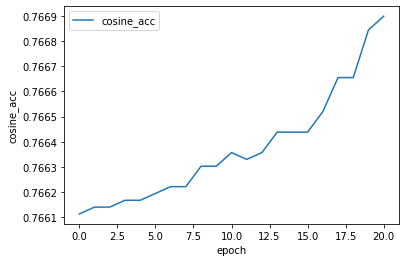

In [45]:
import pandas as pd

eval = pd.read_csv(model_save_path+'/binary_classification_evaluation_results.csv')
eval[['cosine_acc']].plot(xlabel='epoch', ylabel='cosine_acc')

## Load and Use Saved Model

In [18]:
from torch.utils.data import DataLoader
from sentence_transformers import losses, util
from sentence_transformers import LoggingHandler, SentenceTransformer, evaluation
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import csv
import os
from zipfile import ZipFile
import random

In [19]:
# path of saved model
model_save_path

'output/training_OnlineConstrativeLoss-2021-03-19_02-11-20'

In [20]:
model = SentenceTransformer(model_save_path)
# model = SentenceTransformer('http://www.server.com/path/to/model/my_model.zip')

2021-03-19 02:16:14 - Load pretrained SentenceTransformer: output/training_OnlineConstrativeLoss-2021-03-19_02-11-20
2021-03-19 02:16:14 - Load SentenceTransformer from folder: output/training_OnlineConstrativeLoss-2021-03-19_02-11-20
2021-03-19 02:16:15 - Use pytorch device: cuda


In [21]:
"""
This application demonstrates how to find duplicate questions (paraphrases) in a long
list of sentences.
"""

from sentence_transformers import SentenceTransformer, util

# Questions can be a long list of sentences up to 100k sentences or more.
# For demonstration purposes, we limit it to a few questions which all have on duplicate
questions = [
    'How did you catch your spouse cheating?',
    'How can I find out if my husband is cheating?',
    'Is my wife cheating?',
    'How do I know if my partner is cheating?',
    'Why is Starbucks in India overrated?',
    'Is Starbucks overrated in india?',
    'How can I lose weight fast without exercise?',
    'Can I lose weight without exercise?',
    'Which city is the best in India? Why?',
    'Which is the best city in India?',
    'How can I stay focused in class?',
    'How can I stay focused on my school work?',
    'How can I Remotely hack a mobile phone?',
    'How can I hack my phone?',
    'Where should I stay in Goa?',
    'Which are the best hotels in Goa?',
    'Why does hair turn white?',
    'What causes older peoples hair to turn grey?',
    'What is the easiest way to get followers on Quora?',
    'How do I get more followers for my Quora?'
]

#model = SentenceTransformer('distilbert-base-nli-stsb-quora-ranking')
model = SentenceTransformer(model_save_path)

# Given a model and a List of strings (texts), evaluation.ParaphraseMiningEvaluator.paraphrase_mining performs a
# mining task by computing cosine similarity between all possible combinations and returning the ones with the highest scores.
# It returns a list of tuples (score, i, j) with i, j representing the index in the questions list.
pairs = util.paraphrase_mining(model, questions)

#Output Top-20 pairs:
for score, qid1, qid2 in pairs[0:20]:
    print("{:.3f}\t{}\t\t\t{}".format(score, questions[qid1], questions[qid2]))

2021-03-19 02:16:15 - Load pretrained SentenceTransformer: output/training_OnlineConstrativeLoss-2021-03-19_02-11-20
2021-03-19 02:16:15 - Load SentenceTransformer from folder: output/training_OnlineConstrativeLoss-2021-03-19_02-11-20
2021-03-19 02:16:16 - Use pytorch device: cuda
0.912	Which city is the best in India? Why?			Which is the best city in India?
0.911	How can I lose weight fast without exercise?			Can I lose weight without exercise?
0.904	Why is Starbucks in India overrated?			Is Starbucks overrated in india?
0.884	How did you catch your spouse cheating?			How can I find out if my husband is cheating?
0.839	How did you catch your spouse cheating?			How do I know if my partner is cheating?
0.799	How can I Remotely hack a mobile phone?			How can I hack my phone?
0.790	How can I find out if my husband is cheating?			How do I know if my partner is cheating?
0.786	What is the easiest way to get followers on Quora?			How do I get more followers for my Quora?
0.778	Is my wife che